In [0]:
import cv2
from keras.layers import Concatenate,subtract,ZeroPadding2D,Input,Dense,BatchNormalization,LeakyReLU,Flatten,Reshape,Conv2D,Dropout,multiply,Dot,Conv2DTranspose as Deconv2d
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
from google.colab import drive, files
from google.colab.patches import cv2_imshow



In [0]:
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def plot(A,B,C,n):

    samples = [A,B,C]
    fig = plt.figure(figsize=(10,3*n))
    gs = gridspec.GridSpec(3,n)
    g=0
    for i in range(3):
        for j in range(n):
            ax = plt.subplot(gs[g])
            g+=1
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            if samples[i][j].shape == (32,32,1):
              plt.imshow(samples[i][j].reshape(32, 32))
            else:
              plt.imshow(samples[i][j].reshape(32,32,3))

    return fig

In [0]:
from keras.datasets import cifar10
(y, _), (_, _) = cifar10.load_data()

x=np.sum(y, axis=3)/(3*255)

y=y/255
y=y*2-1

x=x.reshape(50000, 32, 32, 1)

print(x.shape)
print(y.shape)
  

170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 1)
(50000, 32, 32, 3)


### Define Generator and Discriminator for GAN

In [0]:
x_shape=(32,32,1)
y_shape=(32,32,3)

In [0]:
def Generator():
	X=Input(shape=x_shape)
	
	Conv1 = Conv2D(64,kernel_size=1,strides=1,input_shape=x_shape)(X)
	Lay1 = LeakyReLU(0.2)(Conv1)
	
	Conv2 = Conv2D(128,kernel_size=2,strides=2)(Conv1)
	Conv2 = LeakyReLU(0.2)(Conv2)
	
	Conv3 = Conv2D(256,kernel_size=2,strides=2)(Conv2)
	Conv3 = LeakyReLU(0.2)(Conv3)
	
	Conv4 = Conv2D(512,kernel_size=2,strides=2)(Conv3)
	Conv4 = LeakyReLU(0.2)(Conv4)
	
	Conv5 = Conv2D(512,kernel_size=2,strides=2)(Conv4)
	Conv5 = LeakyReLU(0.2)(Conv5)
	
	
	DeConv0 = Conv2DTranspose(512,kernel_size=2,strides=2)(Conv5)
	DeConv0 = LeakyReLU(0.2)(DeConv0)
	DeConv0 = BatchNormalization()(DeConv0)
	DeConv0 = Dropout(0.5)(DeConv0)
	DeConv0 = Concatenate(axis=3)([DeConv0,Conv4])
	
	
	DeConv1 = Conv2DTranspose(256,kernel_size=2,strides=2)(DeConv0)
	DeConv1 = LeakyReLU(0.2)(DeConv1)
	DeConv1 = BatchNormalization()(DeConv1)
	DeConv1 = Dropout(0.5)(DeConv1)
	DeConv1 = Concatenate(axis=3)([DeConv1,Conv3])
	
	
	DeConv2 = Conv2DTranspose(128,kernel_size=2,strides=2)(DeConv1)
	DeConv2 = LeakyReLU(0.2)(DeConv2)
	DeConv2 = BatchNormalization()(DeConv2)
	DeConv2 = Concatenate(axis=3)([DeConv2,Conv2])
	
	DeConv3 = Conv2DTranspose(64,kernel_size=2,strides=2)(DeConv2)
	DeConv3 = LeakyReLU(0.2)(DeConv3)
	DeConv3 = BatchNormalization()(DeConv3)
	DeConv3 = Concatenate(axis=3)([DeConv3,Conv1])
	
	FConv4 = Conv2D(3,kernel_size=(1,1),strides=(1,1),activation="tanh")(DeConv3)

	m = Model(X,FConv4)
	
	return m
  

In [0]:
def Discriminator():
	X = Input(shape=x_shape)
	Y = Input(shape=y_shape)
	
	In = Concatenate(axis=3)([X,Y])
	
	Conv1 = Conv2D(64,kernel_size=2,strides=2,input_shape=x_shape)(In)
	Conv1 = BatchNormalization()(Conv1)
	Conv1 = LeakyReLU(0.2)(Conv1)
	Conv2 = Conv2D(128,kernel_size=2,strides=2)(Conv1)
	Conv2 = BatchNormalization()(Conv2)
	Conv2 = LeakyReLU(0.2)(Conv2)
	
	Conv3 = Conv2D(256,kernel_size=2,strides=2)(Conv2)
	Conv3 = BatchNormalization()(Conv3)
	Conv3 = LeakyReLU(0.2)(Conv3)
	
	Conv4 = Conv2D(512,kernel_size=1,strides=1)(Conv3)
	Conv4 = BatchNormalization()(Conv4)
	Conv4 = LeakyReLU(0.2)(Conv4)
	
	Fl = Flatten()(Conv4)
	Fl = Dense(128)(Fl)
	Fl = Dense(1,activation='sigmoid')(Fl)

	m = Model([X,Y],Fl)
	
	return m

In [0]:
# Initiate

X = Input(shape=x_shape)
Y = Input(shape=y_shape)

gen = Generator()
dis = Discriminator()

out = gen(X)
comb = dis([X,out])

out = Flatten()(out)
org = Flatten()(Y)

cos_dis = Dot(axes = 1,normalize = True)([out,org])

combined = Model([X,Y],[comb,cos_dis])












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Training Phrase

In [0]:
genLoss=[]
disLoss=[]

In [0]:
epochs = 20
batch_size = 50
n_example = 50000
batches = int(n_example/batch_size)
dis_updates = 2
gen_updates = 1
zero=np.zeros((batch_size,1))
one=np.ones((batch_size,1))*0.9
d_loss_factor = batches*2*dis_updates
g_loss_factor = batches*gen_updates
reuse = False
adams = Adam(lr = 0.0001)

##############
For Epoch:0
Training Discriminator
Training Generator
Discriminator Loss:0.1642570011631965
Generator loss:0.7948578419685364


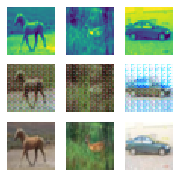

##############
For Epoch:1
Training Discriminator
Training Generator
Discriminator Loss:0.16451048469911667
Generator loss:0.7320743256211281


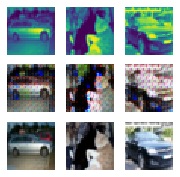

##############
For Epoch:2
Training Discriminator
Training Generator
Discriminator Loss:0.16487352779047773
Generator loss:0.7223956878781319


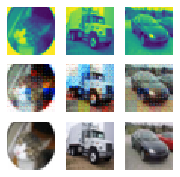

##############
For Epoch:3
Training Discriminator
Training Generator
Discriminator Loss:0.16470488968509925
Generator loss:0.7440521277189255


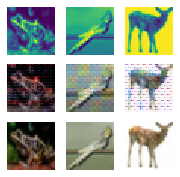

##############
For Epoch:4
Training Discriminator
Training Generator
Discriminator Loss:0.16382116505239377
Generator loss:0.7990463277101517


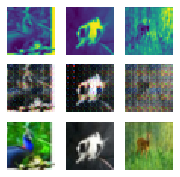

##############
For Epoch:5
Training Discriminator
Training Generator
Discriminator Loss:0.16389677821565965
Generator loss:0.8320564693212509


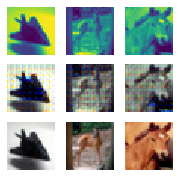

##############
For Epoch:6
Training Discriminator
Training Generator
Discriminator Loss:0.16399490408603196
Generator loss:0.890453102529049


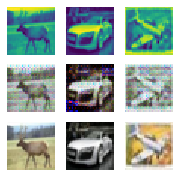

##############
For Epoch:7
Training Discriminator
Training Generator
Discriminator Loss:0.16348632308879338
Generator loss:0.7900364826917649


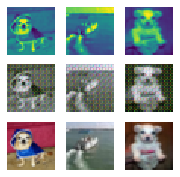

##############
For Epoch:8
Training Discriminator
Training Generator
Discriminator Loss:0.16383136201294554
Generator loss:0.8533679689764977


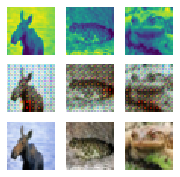

##############
For Epoch:9
Training Discriminator
Training Generator
Discriminator Loss:0.16381465165061923
Generator loss:0.824564259648323


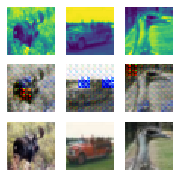

##############
For Epoch:10
Training Discriminator
Training Generator
Discriminator Loss:0.1645041224203719
Generator loss:0.736876691699028


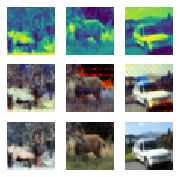

##############
For Epoch:11
Training Discriminator
Training Generator
Discriminator Loss:0.16486538997869934
Generator loss:0.7135549697875977


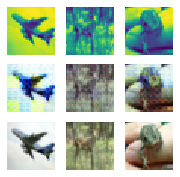

##############
For Epoch:12
Training Discriminator
Training Generator
Discriminator Loss:0.1655547961992654
Generator loss:0.7088378753662109


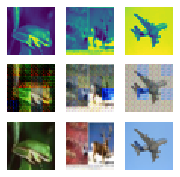

##############
For Epoch:13
Training Discriminator
Training Generator
Discriminator Loss:0.1658917195945637
Generator loss:0.7785174187421798


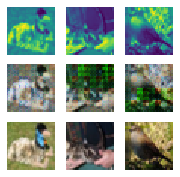

##############
For Epoch:14
Training Discriminator
Training Generator
Discriminator Loss:0.16387593384017407
Generator loss:0.7324992840886116


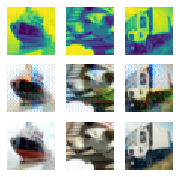

##############
For Epoch:15
Training Discriminator
Training Generator
Discriminator Loss:0.16494767262805726
Generator loss:0.7282224361300469


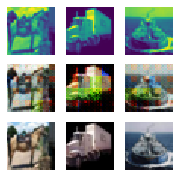

##############
For Epoch:16
Training Discriminator
Training Generator
Discriminator Loss:0.16521851382159572
Generator loss:0.7493813390135765


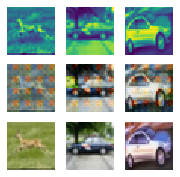

##############
For Epoch:17
Training Discriminator
Training Generator
Discriminator Loss:0.16480804345116143
Generator loss:0.7541534841656685


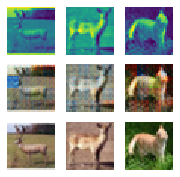

##############
For Epoch:18
Training Discriminator
Training Generator
Discriminator Loss:0.16471627287640309
Generator loss:0.7180532784461975


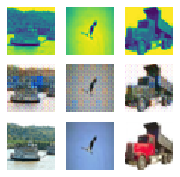

##############
For Epoch:19
Training Discriminator
Training Generator
Discriminator Loss:0.16581778075175407
Generator loss:0.739730480492115


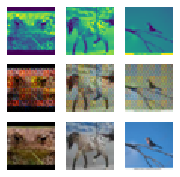

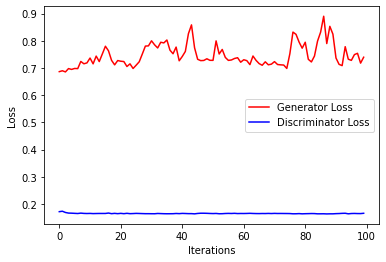

In [0]:

for epoch in range(epochs):
  print("##############")
  print("For Epoch:"+str(epoch))
  
  g_loss = 0
  d_loss = 0
  
  print("Training Discriminator")
  
  i = shuffle(range(n_example))
  
  dis.trainable = True
  dis.compile(loss = "binary_crossentropy",optimizer = adams)
  
  for j in range(dis_updates):
      
    for b in range(batches):
        
      x_batch = x[i[b*batch_size:(b+1)*batch_size]]
      y_batch = y[i[b*batch_size:(b+1)*batch_size]]
      
      pre_batch = gen.predict(x_batch)
      
      d_loss += dis.train_on_batch([x_batch,y_batch],one)
      d_loss += dis.train_on_batch([x_batch,pre_batch],zero)
      
  print("Training Generator")
  
  dis.trainable = False
  combined.compile(loss  = "binary_crossentropy", optimizer = adams)  
  dis.compile(loss = "binary_crossentropy",optimizer = adams)
        
  for  j in range(gen_updates):
    
    for b in range(batches):
      
      x_batch = x[i[b*batch_size:(b+1)*batch_size]]
      y_batch = y[i[b*batch_size:(b+1)*batch_size]]
      
      gl,_,_ = combined.train_on_batch([x_batch,y_batch],[one,one])
      g_loss += gl
      
  g_loss /= g_loss_factor
  d_loss /= d_loss_factor
      
  print("Discriminator Loss:"+str(d_loss))
  print("Generator loss:"+str(g_loss))
  
  genLoss.append(g_loss)
  disLoss.append(d_loss)
  
  gen.save_weights("gdrive/My Drive/ColourBlanca/Generator.h5")
  dis.save_weights("gdrive/My Drive/ColourBlanca/Discriminator.h5")
  


  plt_indices = np.random.randint(50000,size=3)
  plt_a = x[plt_indices]
  plt_b = gen.predict(plt_a)
  plt_b = (plt_b+1)/2
  plt_c = (y[plt_indices]+1)/2
  fig = plot(plt_a,plt_b,plt_c,3)
  plt.show()
  plt.close(fig)
 


plt.plot(genLoss, c='r', label="Generator Loss")
plt.plot(disLoss, c='b', label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [0]:
losses = pd.DataFrame()
losses['disLoss'] = disLoss
losses['genLoss'] = genLoss
losses

,disLoss,genLoss
0,0.171743,0.686703
1,0.173390,0.689965
2,0.168802,0.685744
3,0.166554,0.697949
4,0.166199,0.694942
...,...,...
95,0.164948,0.728222
96,0.165219,0.749381
97,0.164808,0.754153
98,0.164716,0.718053


In [0]:
losses.to_csv('losses_GAN.csv')

In [0]:
gen.save('gan_100ep_model.hdf5')

### Example Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


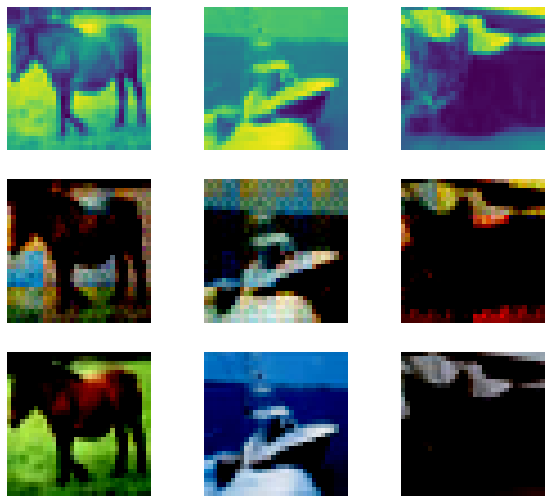

In [0]:
stind = 7
enind = 10
exa = x[stind:enind]
exb = gen.predict(x[stind:enind])
exc = y[stind:enind]
figa = plot(exa,exb,exc,3)
# plt.figure(figsize=(5,8))
plt.show()
plt.close(figa)


### Module for image processing

In [0]:
orig_img = cv2.imread('spo.jpg')
test_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
sizedim = int(np.floor(min(test_img.shape[0:2])/32)*32)
test_img = cv2.resize(test_img,(sizedim,sizedim))
test_img = test_img[:,:,np.newaxis]
test_img.shape

(768, 768, 1)

In [0]:

flag = 0
for i in range(int(sizedim/32)):
  for j in range(int(sizedim/32)):
    temp_addit = test_img[32*i:32*(i+1),32*j:32*(j+1),:]
    if flag==2:
      addit = temp_addit[np.newaxis,:,:,:]
      images_list = np.concatenate([images_list,addit],axis=0)
    if flag==1:
      flag = 2
      images_list = np.stack([images_list,temp_addit],axis=0)
    if flag==0:
      images_list = temp_addit
      flag = 1

if np.mean(images_list)>10:
  images_list = images_list/255
  
images_list.shape

(576, 32, 32, 1)

In [0]:
outss = gen.predict(images_list)

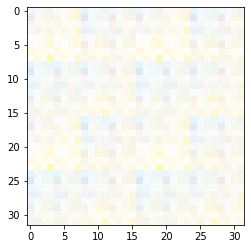

In [0]:
plt.imshow(outss[0][:,:,[2,1,0]])

In [0]:
outss.shape

(576, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


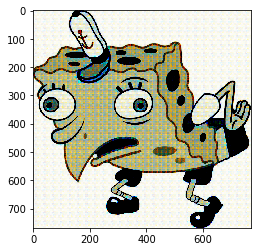

In [0]:
counter = 0
recreated_img = np.zeros((sizedim,sizedim,3))
for i in range(int(sizedim/32)):
  for j in range(int(sizedim/32)):
    img_add = outss[counter,:,:,:]
    recreated_img[32*i:32*(i+1),32*j:32*(j+1),:] = img_add
    counter +=1

plt.imshow(recreated_img[:,:,[2,1,0]])

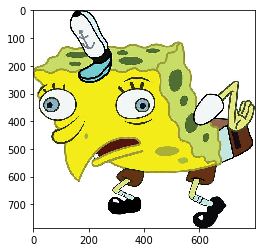

In [0]:
plt.imshow(orig_img[:,:,[2,1,0]])

In [0]:
def image_test(orig_img,model_gen):

  # Process Image to B&W
  test_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)

  # Convert to format that can be input into model
  sizedim = int(np.floor(min(test_img.shape[0:2])/32)*32)
  test_img = cv2.resize(test_img,(sizedim,sizedim))
  test_img = test_img[:,:,np.newaxis]

  # Break image into 32*32 pieces
  flag = 0
  for i in range(int(sizedim/32)):
    for j in range(int(sizedim/32)):
      temp_addit = test_img[32*i:32*(i+1),32*j:32*(j+1),:]
      if flag==2:
        addit = temp_addit[np.newaxis,:,:,:]
        images_list = np.concatenate([images_list,addit],axis=0)
      if flag==1:
        flag = 2
        images_list = np.stack([images_list,temp_addit],axis=0)
      if flag==0:
        images_list = temp_addit
        flag = 1

  # Ensure that model has the right pixel values
  if np.mean(images_list)>10:
    images_list = images_list/255

  # Predict based on Model
  outss = model_gen.predict(images_list)

  # recreate full image
  counter = 0
  recreated_img = np.zeros((sizedim,sizedim,3))
  for i in range(int(sizedim/32)):
    for j in range(int(sizedim/32)):
      img_add = outss[counter,:,:,:]
      recreated_img[32*i:32*(i+1),32*j:32*(j+1),:] = img_add
      counter +=1

  return recreated_img


#### Test function

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


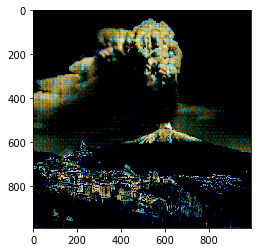

In [0]:
orig_img = cv2.imread('testinghqimg.jpg')
outss = image_test(orig_img,gen)
plt.imshow(outss[:,:,[2,1,0]])
# plt.imshow(orig_img)

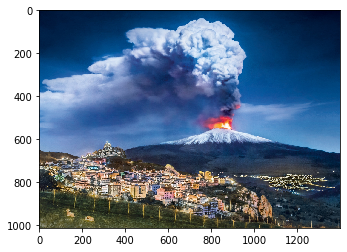

In [0]:
plt.imshow(orig_img[:,:,[2,1,0]])

### Reload Model and try

In [0]:
from keras.models import load_model

loaded_model = load_model('gan_100ep_model.hdf5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
os.getcwd()

'/content/gdrive/My Drive/ColourBlanca/Data'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


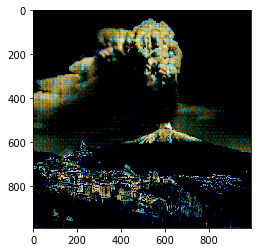

In [0]:
orig_img = cv2.imread('testinghqimg.jpg')
outss = image_test(orig_img,loaded_model)
plt.imshow(outss[:,:,[2,1,0]])

### Function to Colorize black and white

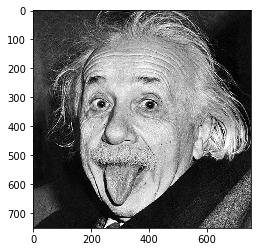

In [0]:
oim = cv2.imread('einstein.jpg')
plt.imshow(oim[:,:,[2,1,0]])

In [0]:
oim.shape

(750, 750, 3)

In [0]:
def bw_to_colour(orig_img,model_gen):

  # Process Image to correct dimensions
  if len(orig_img.shape)==3:
    if orig_img.shape[2]==3:
      test_img = (orig_img[:,:,0]+orig_img[:,:,1]+orig_img[:,:,2])/3
    if orig_img.shape[2]==1:
      test_img = orig_img[:,:,0]
  else:
    if len(orig_img.shape)==2:
      test_img = orig_img

  # Convert to format that can be input into model
  sizedim = int(np.floor(min(test_img.shape[0:2])/32)*32)
  test_img = cv2.resize(test_img,(sizedim,sizedim))
  test_img = test_img[:,:,np.newaxis]

  # Break image into 32*32 pieces
  flag = 0
  for i in range(int(sizedim/32)):
    for j in range(int(sizedim/32)):
      temp_addit = test_img[32*i:32*(i+1),32*j:32*(j+1),:]
      if flag==2:
        addit = temp_addit[np.newaxis,:,:,:]
        images_list = np.concatenate([images_list,addit],axis=0)
      if flag==1:
        flag = 2
        images_list = np.stack([images_list,temp_addit],axis=0)
      if flag==0:
        images_list = temp_addit
        flag = 1

  # Ensure that model has the right pixel values
  if np.mean(images_list)>10:
    images_list = images_list/255

  # Predict based on Model
  outss = model_gen.predict(images_list)

  # recreate full image
  counter = 0
  recreated_img = np.zeros((sizedim,sizedim,3))
  for i in range(int(sizedim/32)):
    for j in range(int(sizedim/32)):
      img_add = outss[counter,:,:,:]
      recreated_img[32*i:32*(i+1),32*j:32*(j+1),:] = img_add
      counter +=1

  return recreated_img




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


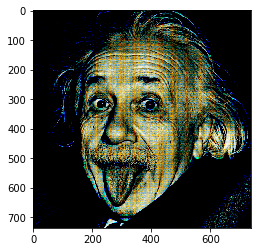

In [0]:
outss = image_test(oim,loaded_model)
plt.imshow(outss[:,:,[2,1,0]])

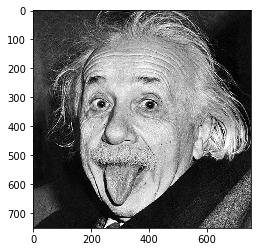

In [0]:
plt.imshow(oim[:,:,[2,1,0]])

### Condense and Colour

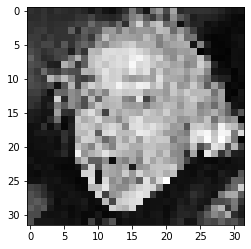

In [0]:
orig_img1 = cv2.imread('einstein.jpg')
oim_res = cv2.resize(orig_img1,(32,32))
plt.imshow(oim_res[:,:,[2,1,0]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


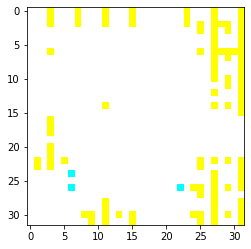

In [0]:
# oim_res = (oim_res[:,:,0]+oim_res[:,:,1]+oim_res[:,:,2])/3
oim_res = cv2.cvtColor(oim_res, cv2.COLOR_BGR2GRAY)
oim_res = oim_res[:,:,np.newaxis]
oim_res = oim_res[np.newaxis,:,:,:]
outss = loaded_model.predict(oim_res)
plt.imshow(outss[0][:,:,[2,1,0]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


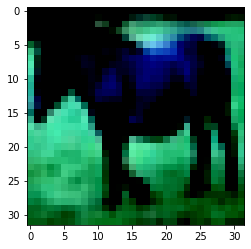

In [0]:
test_ind = 7
plt.imshow(y[test_ind][:,:,[2,1,0]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


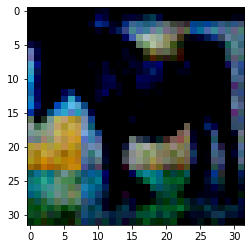

In [0]:
outss = gen.predict(x[test_ind:test_ind+1])
plt.imshow(outss[0][:,:,[2,1,0]])